In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# packages
import elapid as ela

import rasterio as rio
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings

# paths
https = "https://earth-chris.github.io/images/research"
vector = f"{https}/ariolimax-buttoni.gpkg"
raster_names = [
    "ca-cloudcover-mean.tif",
    "ca-cloudcover-stdv.tif",
    "ca-leafareaindex-mean.tif",
    "ca-leafareaindex-stdv.tif",
    "ca-surfacetemp-mean.tif",
    "ca-surfacetemp-stdv.tif",
]
rasters = [f"{https}/{raster}" for raster in raster_names]
labels = [raster[3:-4] for raster in raster_names]

# preferences
%matplotlib inline
mpl.style.use('ggplot')
# warnings.filterwarnings("False")
warnings.simplefilter("always")

print(f"Notebook last run with elapid version {ela.__version__}")


Notebook last run with elapid version 1.0.1


In [3]:
labels

['cloudcover-mean',
 'cloudcover-stdv',
 'leafareaindex-mean',
 'leafareaindex-stdv',
 'surfacetemp-mean',
 'surfacetemp-stdv']

In [4]:
# read the presence data, draw background point samples
presence = gpd.read_file(vector)
background = ela.sample_raster(rasters[0], count=10_000)

# merge datasets and read the covariates at each point location
merged = ela.stack_geodataframes(presence, background, add_class_label=True)
annotated = ela.annotate(merged, rasters, drop_na=True, quiet=True)

# split the x/y data
x = annotated.drop(columns=['class', 'geometry'])
y = annotated['class']


In [5]:
## cross-validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, make_scorer
scorer = make_scorer(roc_auc_score)
clf = ela.MaxentModel(transform='cloglog', beta_multiplier=2.0)
scores = cross_validate(clf, x, y, cv=5, scoring=scorer)


In [6]:
new_x = annotated.drop(columns=['class', 'geometry'])
new_x['longitude'] = annotated.to_crs('EPSG:4326').geometry.centroid.x
new_x['latitude'] = annotated.to_crs('EPSG:4326').geometry.centroid.y
new_x['DOY'] = 1
new_y = annotated['class']

/var/folders/7h/dvwccw_s5f93pgp_lnn__6_40000gn/T/ipykernel_34682/1422646113.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_x['longitude'] = annotated.to_crs('EPSG:4326').geometry.centroid.x
/var/folders/7h/dvwccw_s5f93pgp_lnn__6_40000gn/T/ipykernel_34682/1422646113.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_x['latitude'] = annotated.to_crs('EPSG:4326').geometry.centroid.y


In [7]:
# from sklearn.model_selection import KFold
# from BirdSTEM.model.AdaSTEM import AdaSTEMClassifier

# base_model = ela.MaxentModel(transform='cloglog', beta_multiplier=2.0)
# clf2 = AdaSTEMClassifier(base_model, 
#                  ensemble_fold=10, 
#                  min_ensemble_require=7, 
#                  grid_len_long_upper_threshold=800,
#                  grid_len_long_lower_threshold=1000,
#                  grid_len_lat_upper_threshold=8000,
#                  grid_len_lat_lower_threshold=1000,
#                  points_lower_threshold=50,
#                  temporal_start=1,
#                  temporal_end=1, 
#                  temporal_step=100, 
#                  temporal_bin_interval=100,
#                  stixel_training_size_threshold=50,
#                  save_gridding_plot=False, 
#                  save_tmp=False, 
#                  save_dir='./', 
#                  sample_weights_for_classifier=False)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# score_list = []
# for i in kf.split(new_x, new_y):
#     train_indexes = i[0]
#     test_indexes = i[1]
    
#     clf2.fit(new_x.iloc[train_indexes], new_y.iloc[train_indexes])
#     scores_AdaSTEM = clf2.score(new_x.iloc[test_indexes], new_y.iloc[test_indexes])['AUC']
#     print(scores_AdaSTEM)
#     score_list.append(scores_AdaSTEM)
#     break


In [8]:

# train the model
model = ela.MaxentModel(transform='cloglog', beta_multiplier=2.0)
model.fit(x, y)

# evaluate training performance
ypred = model.predict(x)
auc = metrics.roc_auc_score(y, ypred)
print(f"Training AUC score: {auc:0.3f}")

# save the fitted model to disk
ela.save_object(model, 'demo-maxent-model.ela')

Training AUC score: 0.982


<Axes: >

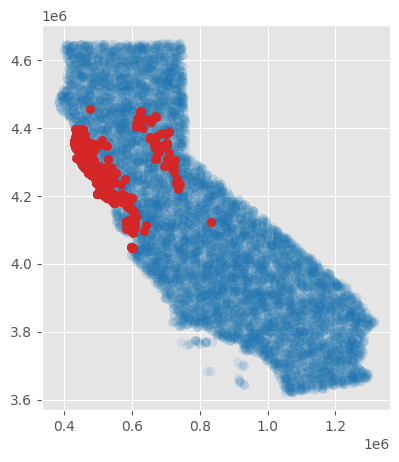

In [24]:
fig,ax = plt.subplots(figsize=(5,5))
background.plot(color='tab:blue',alpha=0.1,ax=ax)
presence.plot(color='tab:red',ax=ax)


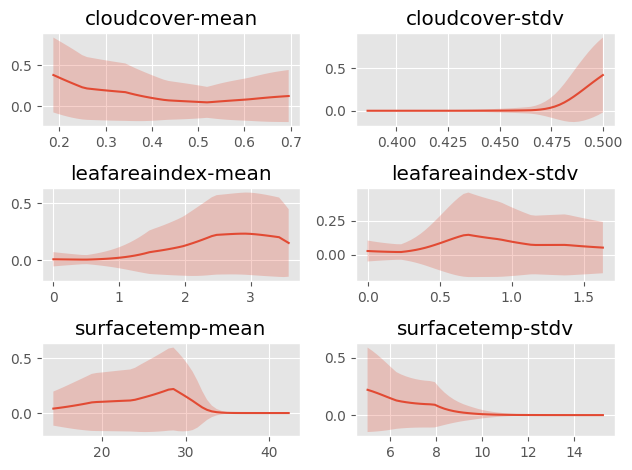

In [4]:
# partial dependence plots show how model predictions vary across the range of covariates
fig, ax = model.partial_dependence_plot(x, labels=labels, dpi=100)


In [25]:
# write the model predictions to disk
output_raster = 'demo-maxent-predictions.tif'
ela.apply_model_to_rasters(model, rasters, output_raster, quiet=True)

# and read into memory
with rio.open(output_raster, 'r') as src:
    pred = src.read(1, masked=True)

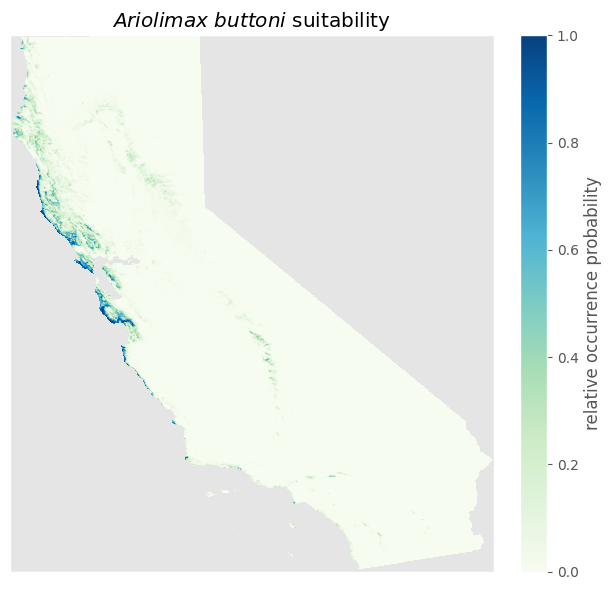

In [26]:
# plot the suitability predictions
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=100)
plot = ax.imshow(pred, vmin=0, vmax=1, cmap='GnBu')
ax.set_title('$Ariolimax\ buttoni$ suitability')
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(plot, ax=ax, label="relative occurrence probability", pad=0.04)
plt.tight_layout()

# with real data

In [85]:
import pandas as pd
import pickle
import numpy as np
from BirdSTEM.model.AdaSTEM import AdaSTEMClassifier
from elapid import MaxentModel

In [23]:


test_sp = 'Short-eared_Owl'
year = 2020
checklist_data = pd.read_csv(f'./BirdSTEM/dataset/test_data/checklist_data/checklist_data_filtered_{year}.csv')
### mallard 2020
with open(f'./BirdSTEM/dataset/test_data/sp_data/{test_sp}/{test_sp}_{year}.pkl','rb') as f:
    sp_data = pickle.load(f)
checklist_data = checklist_data.merge(sp_data, on='sampling_event_identifier', how='left')
checklist_data['count'] = checklist_data['count'].fillna(0)


Besides checklist data, also include background points in the pred set

In [22]:
pred_set = pd.read_csv('./BirdSTEM/dataset/test_data/prediction_set/prediction_set_gridlen10_2020_ERA_bios.txt',sep='\t')
pred_set.columns = [i.lower().replace('-','_').replace(' ','_') for i in pred_set.columns]
pred_set['duration_minutes'] = 60
pred_set['Traveling'] = 1
pred_set['Stationary'] = 0
pred_set['Area'] = 0
pred_set['effort_distance_km'] = 1
pred_set['number_observers'] = 1
pred_set['obsvr_species_count'] = 500
pred_set['time_observation_started_minute_of_day'] = 60*6

fill_neg_one = ['elevation_mean',
 'slope_mean','eastness_mean','northness_mean','elevation_std','slope_std','eastness_std','northness_std',
 'bio1','bio2','bio3','bio4','bio5','bio6','bio7','bio8','bio9','bio10',
 'bio11','bio12','bio13','bio14','bio15','bio16','bio17','bio18','bio19']
pred_set[fill_neg_one] = pred_set[fill_neg_one].fillna(-1)

pred_set[[i for i in pred_set.columns if not i in fill_neg_one]] = \
        pred_set[[i for i in pred_set.columns if not i in fill_neg_one]].fillna(-1)
pred_set['lng_grid'] = np.digitize(
    pred_set.longitude,
    np.arange(pred_set.longitude.min(), pred_set.longitude.max(), 1) ## 1 sample per degree(~110 km)
)

pred_set['lat_grid'] = np.digitize(
    pred_set.latitude,
    np.arange(pred_set.latitude.min(), pred_set.latitude.max(), 1) ## 1 sample per degree(~110 km)
)


reduced_pred_set = pred_set.sample(frac=1, replace=False).groupby(['lng_grid','lat_grid']).first().reset_index(drop=True)
del pred_set


In [34]:
new_background = []
for doy in range(1,367):
    sub = reduced_pred_set.sample(500, replace=False)
    sub['DOY'] = doy
    new_background.append(sub)
new_background = pd.concat(new_background, axis=0)


In [44]:
# Combine the presence and background points
presence_plus_background = pd.concat([
    checklist_data[checklist_data['count']>0],
    new_background
], axis=0)


In [47]:
from BirdSTEM.dataset.get_test_x_names import get_test_x_names
x_names = get_test_x_names()
sampling_effort_vars = ['duration_minutes',
 'Traveling',
 'Stationary',
 'Area',
 'effort_distance_km',
 'number_observers',
 'obsvr_species_count',
 'time_observation_started_minute_of_day']
x_names = list(set(x_names) - set(sampling_effort_vars)) ## remove sampling effor since background points dont have one

X = presence_plus_background[['sampling_event_identifier','longitude','latitude'] + x_names]
# y = np.where(checklist_data['count']>0, 1, 0)
y = presence_plus_background['count'].fillna(0).values

X[x_names] = X[x_names].replace(-1, np.nan)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean').fit(X[x_names])
X[x_names] = imputer.transform(X[x_names])

from sklearn.model_selection import train_test_split
_, X, _, y = train_test_split(X, y, test_size=100000, stratify=np.where(y>0,1,0)) ### reduce the training size


In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3,
                                                    stratify = np.where(y>0, 1, 0), shuffle=True)


In [88]:
# train the model
model = AdaSTEMClassifier(
    base_model=ela.MaxentModel(transform='cloglog', beta_multiplier=2.0, clamp=False),
    ensemble_fold=5,
    min_ensemble_require=3,
    grid_len_lon_lower_threshold=8888,
    grid_len_lon_upper_threshold=8888,
    grid_len_lat_lower_threshold=8888,
    grid_len_lat_upper_threshold=8888
    )


model.fit(X_train[x_names + ['longitude','latitude']], np.where(y_train>0,1,0))

# evaluate training performance
ypred = model.predict(X_train[x_names + ['longitude','latitude']])
auc1 = metrics.roc_auc_score(np.where(y_train>0,1,0), np.where(ypred>0.5, 1, 0))
print(f"Training AUC score: {auc1:0.3f}")
ypred = model.predict(X_test[x_names + ['longitude','latitude']])
auc2 = metrics.roc_auc_score(np.where(y_test>0,1,0), np.where(ypred>0.5, 1, 0))
print(f"Testing AUC score: {auc2:0.3f}")

# save the fitted model to disk
ela.save_object(model, 'demo-maxent-model.ela')

Generating Ensemble: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Saved! ./ensemble_quadtree_df.csv


training: 100%|██████████| 97/97 [06:21<00:00,  3.93s/it]


Training AUC score: 0.897
Testing AUC score: 0.912


In [92]:
aa = checklist_data[x_names + ['longitude','latitude']]
aa[x_names] = imputer.transform(aa[x_names].replace(-1,np.nan))
true_pred = model.predict(
    aa # this include true absence, and no background
)


In [93]:
auc3 = metrics.roc_auc_score(np.where(checklist_data['count']>0,1,0), np.where(true_pred>0.5, 1, 0))
print(f"True AUC score: {auc3:0.3f} (probably still a little bit higher)")


True AUC score: 0.500 (probably still a little bit higher)


# Predict on pred_set

In [95]:
import os
from BirdSTEM.utils.plot_gif import *
from tqdm.auto import tqdm
global SAVE_DIR
SAVE_DIR = f'./test_output/{test_sp}/{year}'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [98]:
res_list = []

DOY=1
for DOY in tqdm(range(1, 367)):
    reduced_pred_set['DOY'] = DOY
    reduced_pred_set[x_names] = reduced_pred_set[x_names].replace(-1, np.nan)
    reduced_pred_set[x_names] = imputer.transform(reduced_pred_set[x_names])
    pred_mean= model.predict(reduced_pred_set[x_names + ['longitude','latitude']])

    tmp = pd.DataFrame({
        'longitude':reduced_pred_set.longitude.values,
        'latitude':reduced_pred_set.latitude.values,
        'pred_mean':pred_mean
    })
    
    tmp['DOY'] = DOY
    res_list.append(tmp)


  0%|          | 0/366 [00:00<?, ?it/s]

In [99]:
pred_whole_year = pd.concat(res_list, axis=0)


In [100]:
pred_whole_year.to_csv(os.path.join(SAVE_DIR, 'pred_whole_year.csv'), index=False)
pred_whole_year['pred_mean_absolute'] = np.where(pred_whole_year['pred_mean']<0, 0, pred_whole_year['pred_mean'])


0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.27

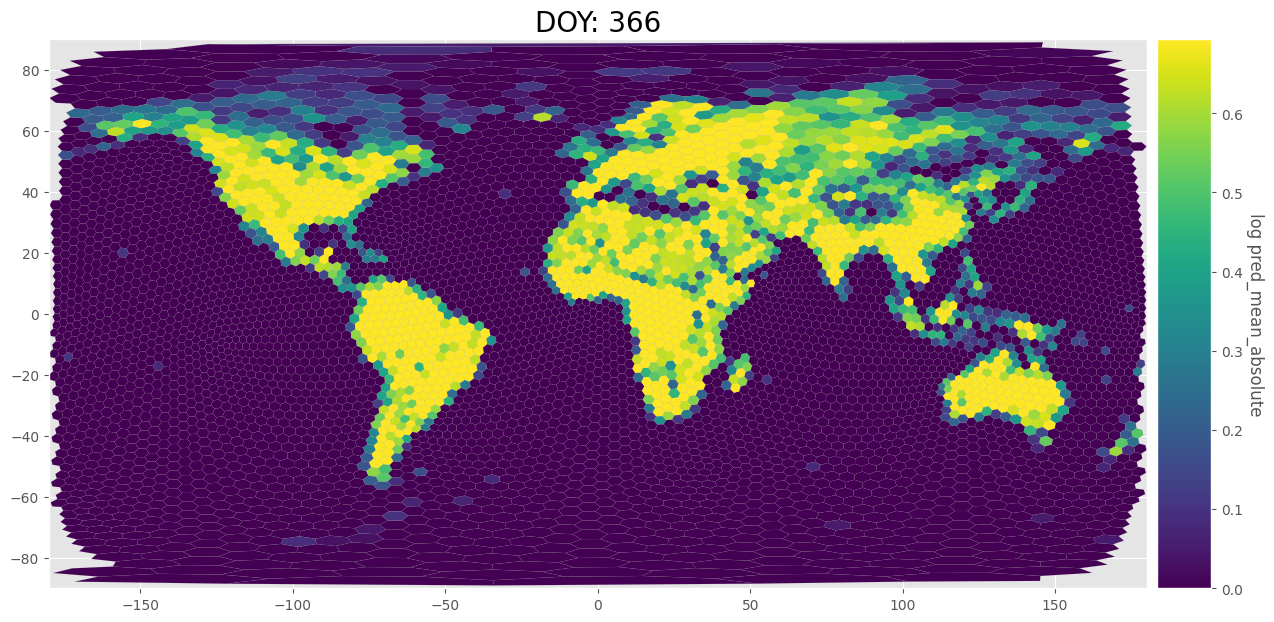

In [101]:
make_sample_gif_hexagon(pred_whole_year , os.path.join(SAVE_DIR, 'Sample_prediction_results.gif'), 
                        col='pred_mean_absolute', log_scale=True, dpi=100, fps=30)


# AdaSTEM

In [94]:
from sklearn.model_selection import KFold
from BirdSTEM.model.AdaSTEM import AdaSTEMClassifier
base_model = ela.MaxentModel(transform='cloglog', beta_multiplier=2.0)

# new_X_train = X_train.copy()
# new_X_train['DOY'] = 1
clf2 = AdaSTEMClassifier(base_model, 
                 ensemble_fold=5, 
                 min_ensemble_require=3, 
                 grid_len_long_upper_threshold=50,
                 grid_len_long_lower_threshold=10,
                 grid_len_lat_upper_threshold=50,
                 grid_len_lat_lower_threshold=10,
                 points_lower_threshold=50,
                 temporal_start=-1,
                 temporal_end=1, 
                 temporal_step=1000, 
                 temporal_bin_interval=1000,
                 temporal_bin_start_jitter = 0, ## random, or a float/int
                 stixel_training_size_threshold=50,
                 save_gridding_plot=False, 
                 save_tmp=False, 
                 save_dir='./', 
                 sample_weights_for_classifier=False)
clf2.fit(X_train[x_names + ['longitude','latitude']], np.where(y_train>0,1,0))


training: 100%|██████████| 712/712 [00:36<00:00, 19.48it/s] 


In [96]:
# evaluate training performance
mean, std = clf2.predict_proba(X_train[x_names + ['longitude','latitude']])
a = pd.DataFrame({
    'y_train':np.where(y_train>0,1,0), 
    'y_pred':mean
}).dropna()
auc1 = metrics.roc_auc_score(a.y_train, a.y_pred)
print('Training:', auc1)


mean, std = clf2.predict_proba(X_test[x_names + ['longitude','latitude']])
a = pd.DataFrame({
    'y_test':np.where(y_test>0,1,0), 
    'y_pred':mean
}).dropna()
auc2 = metrics.roc_auc_score(a.y_test, a.y_pred)
print('Testing:', auc2)


Training: 1.0
Testing: 0.7355776558451455


In [100]:
pd.DataFrame({
    'y_test':np.where(y_test>0,1,0), 
    'y_pred':mean
}).isnull().sum()

y_test        0
y_pred    21246
dtype: int64

In [101]:
pd.DataFrame({
    'y_test':np.where(y_test>0,1,0), 
    'y_pred':mean
}).shape

(30000, 2)